## EDA of House Price Prediction data

### Overview

##### PATHS, DEPENDENCIES AND CUSTOM CLASSES
  - Paths
  - Dependencies
  - Classes
    - PreProcess
    - EDA

##### STUDY AND CLEAN FEATURES
  - Summarize features
  - Find missing features
  - Filling Missing values
    - Histogram Plots
    - Box Plots
    - Fillingn Strategy - Mean, Median, Mode, NAN_CLASS
  - Group Features - Categorical & Continueous
    - Based on #Classes
    - Based on Type of Columns (int64, object)
    - Based on Manual Configuration (config.yml)
  - Last Check - Ensure data is clean

##### FEATURES IMPORTANCE
  - Target distribution
  - Categorical
    - Distribution
    - Feature vs Target
      - Box Plots
      - Violin Plots
    - Drop Features with >80% Missing values
    - Select best features
      - chi2 analysis
  - Continueous
    - Distribution
    - Feature vs Target
      - Pearson Analysis - r-value, p-value
    - Select best features
  - Visualize the features
    - PCA
    - TSNE
  - Concatenate above 2 groups

##### TRY & COMPARE MODELS

- [Document contains the complete flow](https://docs.google.com/document/d/14CjFWvGZS9hyNudNY46WK1OasQNBuOrobnsO2wGEXR8/edit?usp=sharing)

#### PATHS, DEPENDENCIED and CUSTOM CLASSES

In [65]:
# Paths
PWD = "/home/hanchau/proj/ds/spinny/"
TRAIN_DATA = "data/house_train.csv"
TEST_DATA = "data/house_test.csv"
CONFIG = "config.yml"
import os; os.chdir(PWD)

# Dependencies
import yaml
import time
import numpy as np
import pandas as pd
import seaborn as sns
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
import warnings; warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

plt.style.use('bmh')

# Helpers & Utils
class PreProcess:
    """
        PreProcess: Library for pre processing
    """

    def load_data(path):
        """
        Loading data
        """
        ret = pd.read_csv(path)
        print(f"Loaded file: {path}")
        return ret


    def drop_un(df, cols):
        """
        Dropping unnecessary features
        """
        try: 
            ret = df.drop(cols, axis=1)
            print(f"Dropped Columns: {cols}")
            return ret
        except: 
            ret = df.drop(cols[-1], axis=1)
            print(f"Dropped Columns: {cols[-1]}")
            return ret
    
    def drop_missing(df, thresh=0.8, cols=''):
        """
        Dropping features with more than threshold Missing Values
        """
        skipped_cols = []
        dropped_cols = []

        if not cols: cols = df.columns
        thresh = df.shape[0] * thresh

        for col in cols:
            try:
                agg = df[col].value_counts().to_frame(name='counts').T
                try: crossed_thresh = (agg['NAN_CLASS'] > thresh).any()
                except: continue
                if crossed_thresh:
                    dropped_cols.append(col)
                    print(f"dropped col {col}")
                    df.drop(col , inplace=True, axis=1)
            except Exception as e:
                print(e) 
                skipped_cols.append(col)

        print(f"Dropped columns: {dropped_cols}, Couldn't Drop Columns: {skipped_cols}")
        return dropped_cols


    def check_nan(df, col):
        """
        Check nan values for each class of a feature
        """
        ret = df[col].isnull().values.sum()
        print(f"Checking nan in: {col}")
        return ret


    def count_nan(df, cols):
        """
        Check nan values for a feature
        """
        ret = df[cols].isna().sum().to_frame(name='counts')

        print(f"Counted the nan values in: {cols}")
        return ret


    def count_unique(df, cols = []):
        """
        Counts the classes for each feature
        """
        if len(cols) == 0: 
            ret = df[df.columns].nunique().to_frame(name='counts')
        else:
            ret = df.nunique().to_frame(name='counts')

        print(f"Counted the Unique Classes in: {cols}")
        return ret


    def group_feat_on_classes(df, col='counts', thres = 25):
        """
        Returns: the Categorical and Continueous features in 2 groups
        Input: Takes the feature-count dataframe as input
        
        Parameters
        ----------
            thres: features with distinch values < thres will be treated as categorical
            col: count column in dataframe
        """
        feat_categ = list(df[df[col] <= thres].T.columns)
        feat_cont = list(set(df.T.columns) - set(feat_categ))
        return feat_categ, feat_cont

    
    def group_feat_on_types(df):
        """
        Returns: the Categorical and Continueous features in 2 groups
        Input: Takes the dataframe as input
        """
        feat_categ = list(df.select_dtypes(include=['int64']).columns)
        feat_cont = list(set(df.columns) - set(feat_categ))
        return feat_categ, feat_cont


    def group_feat_on_manual(df, config_path):
        """
        Returns: the Categorical and Continueous features in 2 groups
        Input: Takes the external configuration as input
        """
        with open(CONFIG, "r") as config:
            config = yaml.load(config, Loader=yaml.FullLoader)
        feat_cont = config.get("continueous_feat")
        feat_categ = list(set(df.columns) - set(feat_cont) - set(config.get("target_feat")))
        return feat_categ, feat_cont

  
    def make_cat(df, col, bins, labels):
        """
        Make custom groups/classes
        """
        df[col] = pd.cut(df[col], bins=bins, labels=labels)
        print(f"Made custom classes: {labels}")


    def check_agg(df, col):
        """
        Check class level aggregates for a column
        """
        ret = pd.DataFrame(df[col].value_counts())
        print(f"Checking counts in: {col}")
        return ret


    def check_agg_all(df, cols = ''):
        """
        Check class level aggregates for all columns
        """
        ret = []
        if not cols: cols = df.columns
        for col in cols:
            ret.append(pd.DataFrame(df[col].value_counts()))
        print(f"Checking class aggregates of all Columns:", end="\n")
        return ret


    def fill_na(df, cols, kind='mode'):
        """
        Various strategies for filling nan
        
        Parameters
        ----------
            type: mean, median, mode, nan_class
        """

        def fill_mode():
            """
            Modes can be multiple, pick the first one
            """
            for col in cols:
                df[col].fillna(df[col].mode()[0], inplace=True)

        def fill_median():
            for col in cols:
                df[col].fillna(df[col].median(), inplace=True)

        def fill_mean():
            for col in cols:
                df[col].fillna(df[col].mean(), inplace=True)

        def fill_nan_class():
            for col in cols:
                df[col].fillna("NAN_CLASS", inplace=True)

        if kind=='mode':
            fill_mode()
        elif kind=='mean':
            fill_mean()
        elif kind=='median':
            fill_median()
        elif kind=='nan_class':
            fill_nan_class()

        print(f"Fill NAN strategy: {kind}")


    def info(df):
        """
        Get the basic info of data frame
        """
        shape = df.shape
        print(f"All features and Null Counts:", end="\n") 
        return df.info()
        print("\n\n\n")
    

    def get_nan(df):
        """
        Get the columns with nan to handle
        """
        ret = df.columns[df.isna().any()].tolist()
        print(f"#NAN columns: {len(ret)}, NAN columns: {ret}", end="\n\n") 
        return ret


    def describe(df):
        """
        Comprehensive aggregates description of all features
        """
        print(f"Comprehensive aggregate description", end="\n")
        return df.describe(include='all').T


    def describe_missing(df):
        """
        Comprehensive aggregates description of the features with nan values
        """
        print(f"Aggregate description for Missing", end="\n")
        ret = df.describe(include='all').T
        ret = ret[ret['count'] != df.shape[0]]
        print(ret)
        return ret


    def encode_categ(df, cols = []):
        """
        Encdoe the Categorical Features in numerical values
        Ouput:
        -----
            encode_map = {
                col1: {class11: 0, class12: 1}
                col2: {class21: 0, class22: 1, class23: 2}
                ...
                heating: {Po: 1, Fa: 2, TA: 3, Go: 4, Ex: 5}
            }
        """
        encode_map = {}
        qual_elem = {'Ex', 'Gd', 'TA', 'Fa', 'Po', 'NAN_CLASS'}
        qual_elem_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NAN_CLASS": 0}

        qual_elem1 = {'No', 'Mn', 'Av', 'Gd', 'NAN_CLASS'}
        qual_elem_map1 = {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NAN_CLASS": 0}
        

        def qual_type(col):
            df_unique = set(df[col].unique())
            if (len(df_unique) < 7) and len(df_unique.intersection(qual_elem)) > 3: return "case 0"
            elif (len(df_unique) < 7) and len(df_unique.intersection(qual_elem1)) > 3: return "case 1"
            return 'no case'

        if not cols: cols = df.columns

        for col in cols:
            case = qual_type(col)
            if case == 'case 0':
                encode_map[col] = qual_elem_map
            elif case == 'case 1':
                encode_map[col] = qual_elem_map1
            else:
                encode_map[col] = {k:i for i, k in enumerate(df[col].unique())}
            df[col] = df[col].map(encode_map.get(col))

        return encode_map



class EDA:
    """
    EDA: Library for ploting and analysing after Pre Processing
    """

    def describe(df, cols = ''):
        """
        Comprehensive aggregates description of all features
        """
        print(f"Comprehensive aggregate description", end="\n")
        if not cols:
            ret = df.describe(include='all').T
        ret = df[cols].describe(include='all').T
        return ret



    def set_palette():
        """
        Set the colors that will be used in the EDA plots
        """
        custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
        customPalette = sns.set_palette(sns.color_palette(custom_colors))
        sns.palplot(sns.color_palette(custom_colors),size=1)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        return custom_colors


    def get_palette(colors, color):
        """
        Get a gradient type color palette
        """
        palette = sns.dark_palette(colors[color], reverse=True)
        sns.palplot(sns.color_palette(palette),size=1)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        return palette


    def get_pearson_corr(df, cols=[], target='SalePrice'):
        """
        Get the pearson coefficient of correlation for all the features-target pair
        """
        corr = []
        for col in cols:
            stp = stats.pearsonr(df[col], df[target])
            corr.append([col, stp[0], stp[1]])
        corr = pd.DataFrame(corr, columns = ["feat", "r-value", "p_value" ])
        corr = corr.sort_values(by='r-value', ascending=False, ignore_index=True)
        styled = corr.style.background_gradient(cmap='Reds')
        return corr, styled


    def plot_grad(df, col):
        """
        Simple plot of x vs y
        """ 
        print(f"Gradient plot of: {col}")
        ret = df.sort_values(by=col, ascending=False).style.background_gradient(cmap='Reds')
        return ret


    def plot_dist(df, col):
        """
        Simple plot of distribution of samples across col values
        """
        print(f"Ploting columns: {col}", end="\n")
        sns.displot(df[col])


    def plot_box(df, cols):
        """
        Simple box plot
        """
        print(f"Ploting box: {cols}", end="\n")
        plt.figure(figsize=(15,5))
        i = 1
        for col in cols:
            plt.subplot(1,3,i)
            a1 = sns.boxplot(data=df,y=col)
            i+=1
 

    def plot_dist_all(df, cols = [], kind = 'box', target = '', section = 2, size=5):
        """
        Simple plots of distribution of samples across all columns

        Parameters
        ----------
            df:  data
            cols:  cols to consider
            kind:  which kind of plot
            target:  values on y axes
            section:  no. of columns of subplots
            size: size of subplots
        TODO:
            Add feature of axis - ax=axes[i//section, i%section], 
        """
        print(f"Plotting all features distribution.\nIt may take a while..", end="\n\n")
        skipped_cols = []

        if cols == []: cols = df.columns 
                
        rows = len(cols)//section
        fig, axes = plt.subplots(rows, section, figsize=(section* size, rows*size))
        
        for row in range(0, rows):
            for secs in range(0, section):
                i = row*section + secs
                if i < len(cols):
                    try: 
                        if kind == 'box':
                            sns.boxplot(data=df, x=cols[i], y=target, ax=axes[row, secs])
                        elif kind == 'violin':
                            sns.violinplot(data=df, x=cols[i], y=target, ax=axes[row, secs])
                        elif kind == 'hist':
                            sns.displot(data=df, x=cols[i], kind='hist')
                        elif kind == 'kde':
                            sns.displot(data=df, x=cols[i], kind='kde')
                        elif kind == 'ecdf':
                            sns.displot(data=df, x=cols[i], kind='ecdf', ax=axes[row, secs])
                        elif kind == 'bar':
                            sns.barplot(ax=axes[row, secs], data=df, x=cols[i], y=target)
                    except Exception as e: 
                        print(e)
                        skipped_cols.append(cols[i])
        return skipped_cols


    def plot_hist_all(df, cols = [], bins = 50, size = (10, 10)):
        """
        Plots simple histogram distribution of given columns
        """
        if cols == []: cols = df.columns
        temp = df[cols]
        temp.hist(figsize=size, bins=bins, xlabelsize=8, ylabelsize=8)


    def pair_wise_corr(df, cols = [], size = (10,10), section=2, target='SalePrice', colors=[]):
        rows = len(cols)//section
        secs = section
        corr = []

        fig, axs = plt.subplots(rows, secs, figsize=(secs*3.5,rows*3))


        for r in range(0,rows):
            for c in range(0,secs):
                i = r*secs + c
                if i < len(cols):
                    color = colors[i%secs]
                    sns.regplot(df[cols[i]], df[target], ax = axs[r][c], color=color)
                    stp = stats.pearsonr(df[cols[i]], df[target])
                    str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
                    axs[r][c].set_title(str_title,fontsize=11)
        plt.tight_layout()    
        plt.show()  


    def corr_cont_feat(df, cols, size = (10,20)):
        """
        Plot corr b/w cont features
        """
        corr = df[cols].corr()

        plt.figure(figsize=size)
        sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True)


    def plot_cont(df, col):
        """
        Plot contingency matrix for a column
        """
        pass


    def plot_cont_all(df, cols = []):
        """
        Plot contingency matrix for all columns
        """
        pass



# Data loading
data = PreProcess.load_data(TRAIN_DATA)
t_data = PreProcess.load_data(TEST_DATA)

Loaded file: data/house_train.csv
Loaded file: data/house_test.csv


#### STUDY AND CLEAN FEATURES

    1. There are 80 Features with 18 features having Missing Values
    1. The #samples we have here are - 1168

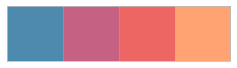

In [2]:
# Set the working palette
colors = EDA.set_palette()

In [3]:
# PreProcess.info(data)
desc = PreProcess.describe(data)
desc

Comprehensive aggregate description


count unique     top  freq           mean           std  \
Id             1168.0    NaN     NaN   NaN          583.5    337.316864   
MSSubClass     1168.0    NaN     NaN   NaN      57.251712     42.189213   
MSZoning         1168      5      RL   912            NaN           NaN   
LotFrontage     982.0    NaN     NaN   NaN      70.092668     24.737533   
LotArea        1168.0    NaN     NaN   NaN   10571.564212  10543.102521   
...               ...    ...     ...   ...            ...           ...   
MoSold         1168.0    NaN     NaN   NaN       6.357877      2.679448   
YrSold         1168.0    NaN     NaN   NaN    2007.797945      1.328069   
SaleType         1168      9      WD  1008            NaN           NaN   
SaleCondition    1168      6  Normal   956            NaN           NaN   
SalePrice      1168.0    NaN     NaN   NaN  180657.954623  77261.558314   

                   min       25%       50%       75%       max  
Id                 0.0    291.75     583.5    875.25    1167.0  
MSSubClass        20.0      20.0      50.0      70.0     190.0  
MSZoning           NaN       NaN       NaN       NaN       NaN  
LotFrontage       21.0      59.0      69.0      80.0     313.0  
LotArea         1300.0   7487.25    9355.0   11530.0  215245.0  
...                ...       ...       ...       ...       ...  
MoSold             1.0       5.0       6.0       8.0      12.0  
YrSold          2006.0    2007.0    2008.0    2009.0    2010.0  
SaleType           NaN       NaN       NaN       NaN       NaN  
SaleCondition      NaN       NaN       NaN       NaN       NaN  
SalePrice      34900.0  130000.0  163500.0  213000.0  755000.0  

[81 rows x 11 columns]


      1. There are two types of features --> Categorical and Continueous
      2. All the features are mentioned  

[here](https://docs.google.com/document/d/14CjFWvGZS9hyNudNY46WK1OasQNBuOrobnsO2wGEXR8/edit?usp=sharing)

In [4]:
# Categorical or Continueous
agg = PreProcess.check_agg_all(data)
print(agg[0])

Checking class aggregates of all Columns:
      Id
0      1
767    1
783    1
782    1
781    1
...   ..
388    1
387    1
386    1
385    1
1167   1

[1168 rows x 1 columns]


In [6]:
# Missing Values
nan_cols = PreProcess.get_nan(data)
missing = PreProcess.count_nan(data, nan_cols)
EDA.plot_grad(missing, col='counts')

# Plot separate hist for each column
# for col in data.columns:
#     EDA.plot_dist(data, col=col)

#NAN columns: 18, NAN columns: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Counted the nan values in: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Gradient plot of: counts


Comprehensive aggregate description
Aggregate description for Missing
               count unique     top  freq        mean         std     min  \
LotFrontage    982.0    NaN     NaN   NaN   70.092668   24.737533    21.0   
Alley             74      2    Grvl    39         NaN         NaN     NaN   
MasVnrType      1161      4    None   696         NaN         NaN     NaN   
MasVnrArea    1161.0    NaN     NaN   NaN  104.009475  181.134311     0.0   
BsmtQual        1135      4      TA   525         NaN         NaN     NaN   
BsmtCond        1135      4      TA  1046         NaN         NaN     NaN   
BsmtExposure    1134      4      No   761         NaN         NaN     NaN   
BsmtFinType1    1135      6     Unf   339         NaN         NaN     NaN   
BsmtFinType2    1135      6     Unf  1005         NaN         NaN     NaN   
FireplaceQu      614      5      Gd   312         NaN         NaN     NaN   
GarageType      1103      6  Attchd   690         NaN         NaN     NaN   
Garage

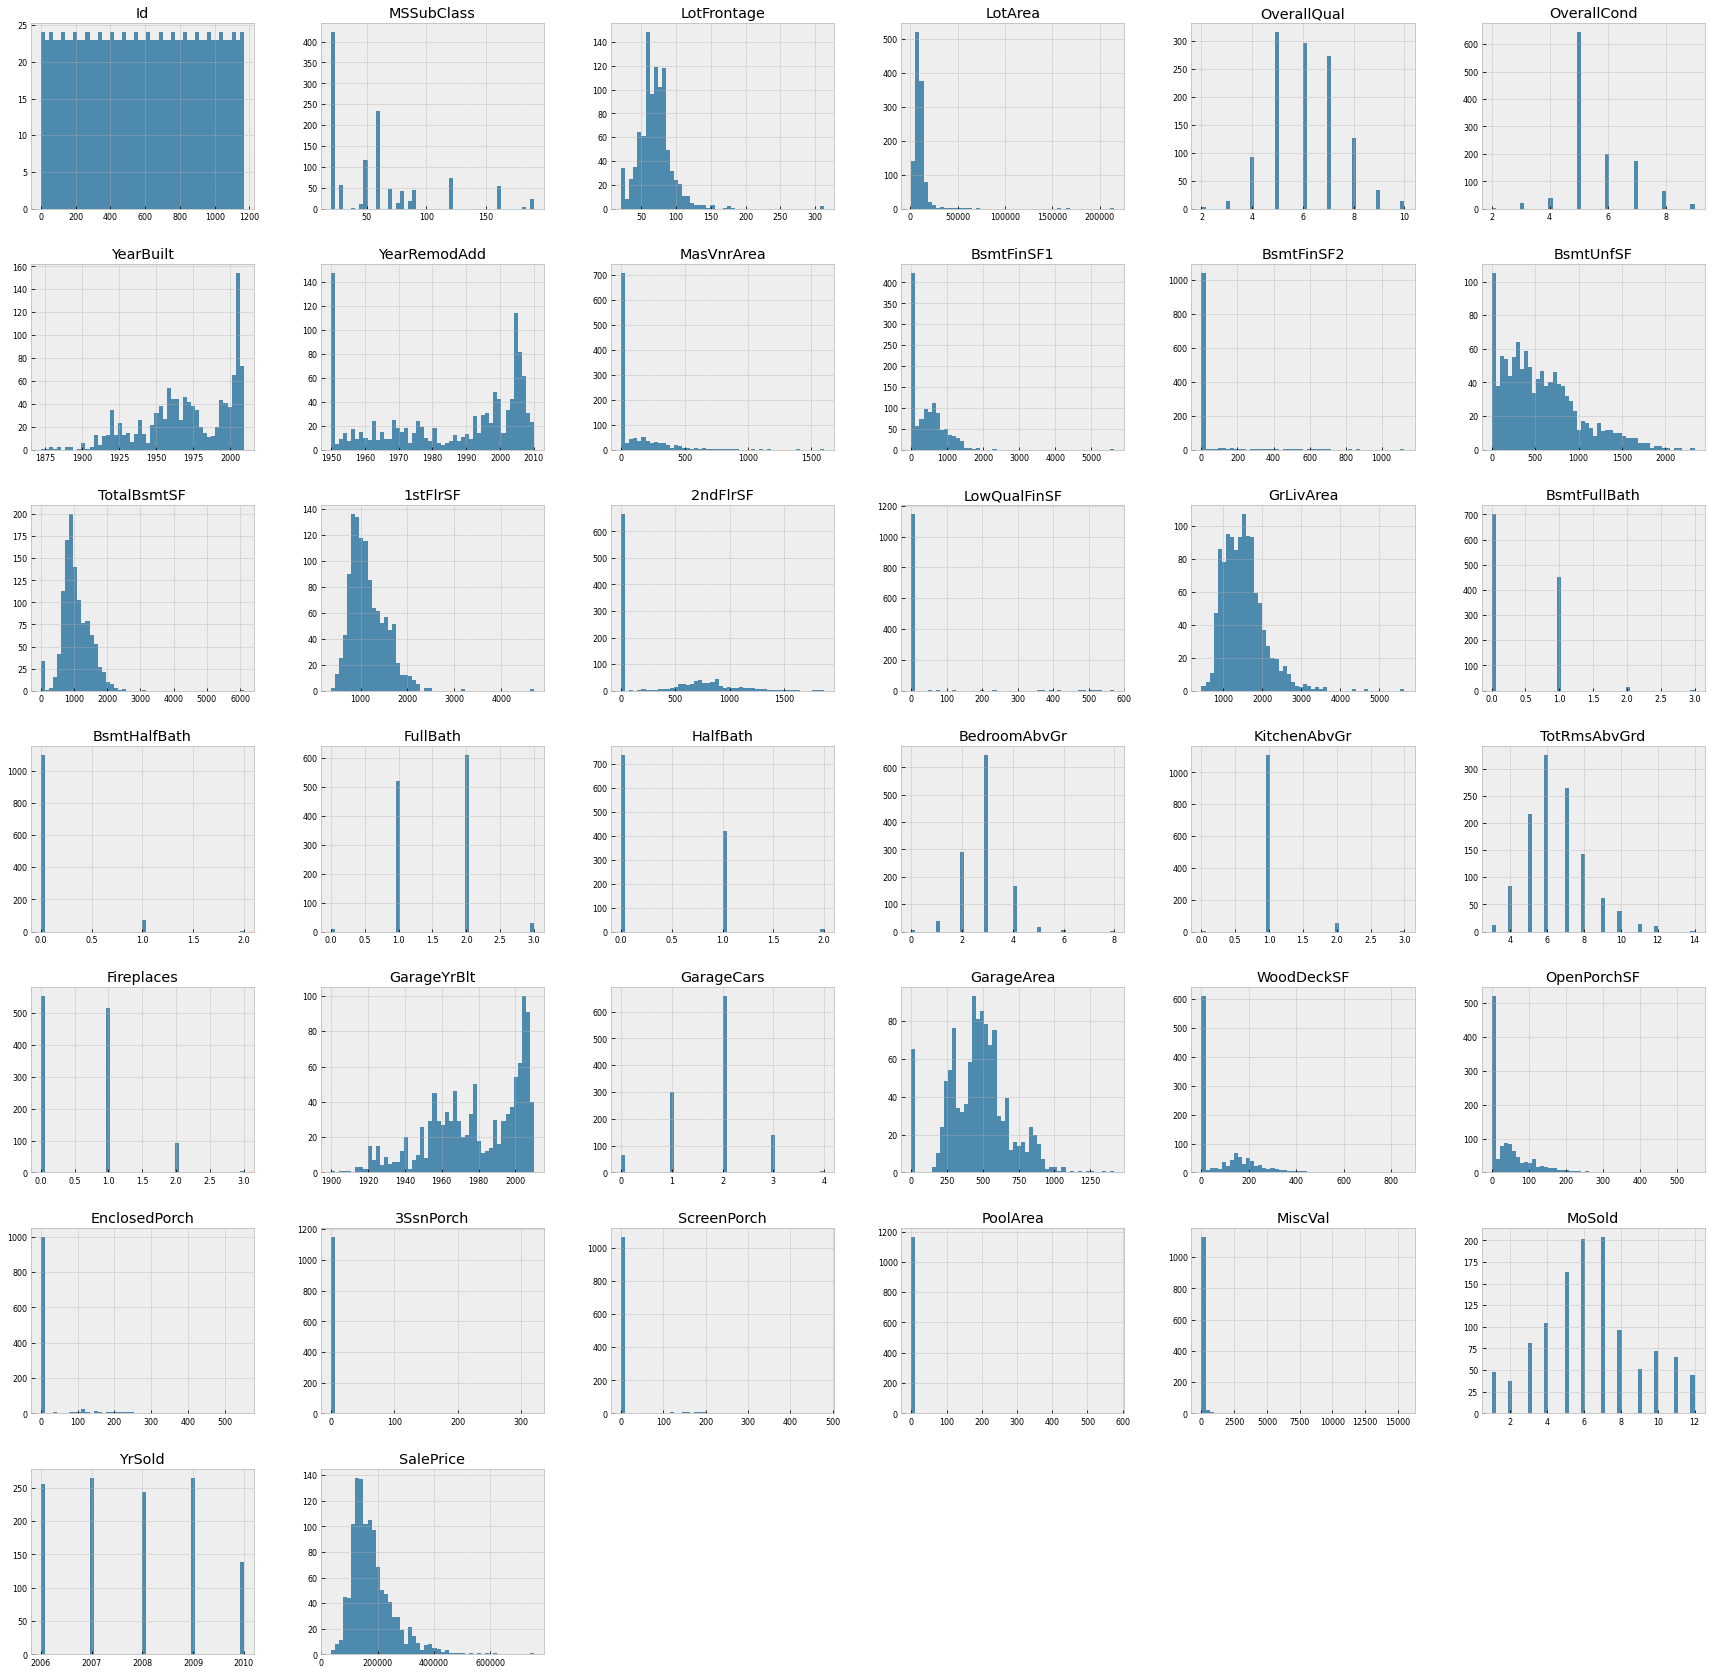

In [7]:
# Figuering out "Filling missing values" strategy


# Description of all data
desc = PreProcess.describe(data)


# Distribution - hist
EDA.plot_hist_all(data, size = (30,30))


# Discription of Missing Data Features
desc = PreProcess.describe_missing(data)

# Distribution for indivudal hist
# for col in data.columns:
#     EDA.plot_dist(data, col=col)

    Unnecessary Columns
    1. Id - has no use in further prediction, so dropping it off
    
    Missing Vlaues
    
    These 3 feature have missing values becuase of improper data

    1. GarageYrBlt   - nan are missing values - [Mode]
    2. LotFrontage    - skewed normal distribution - [Median]
    3. MasVnrArea     - nan are missing values, 0 are more than half - [Mode]

    These 15 features have missing or nan values becuase it represents a separate class   

    1. PoolQC         - nan means the pool is absent in the property - [NAN class]
    2. Alley          - nan means no alley access - [NAN class]
    3. MasVnrType     - nan means no masonry veneeer types - [NAN class]
    4. BsmtQual       - nan means no basement - [NAN class]
    5. BsmtCond       - nan means no basement - [NAN class]
    6. BsmtExposure   - nan means no basement - [NAN class]
    7. BsmtFinType1   - nan means no basement - [NAN class]
    8. BsmtFinType2   - nan means no basement - [NAN class]
    9. FireplaceQu    - nan means no fireplace - [NAN class]
    10. GarageType    - nan means no fireplace - [NAN class]
    11. GarageFinish  - nan means no garage - [NAN class]
    12. GarageQual    - nan means no garage - [NAN class]
    13. GarageCond    - nan means no garage - [NAN class]
    14. Fence         - nan means no fence - [NAN class]
    15. MiscFeature   - nan means no misc feature - [NAN class]

    Filling Strategy 

    1. If the data is centered around mean --> Fill the mean or median
    2. If the data is categorical --> Fill mode

    Observation

    1. In LotFrontage --> Median can be used because points are mostly centered around Mean
    2. In other two cases --> Mode seems to be the best alternative

Dropped Columns: ['Id']
Ploting box: ['GarageYrBlt', 'MasVnrArea', 'LotFrontage']
Comprehensive aggregate description


count         mean         std     min     25%     50%     75%  \
GarageYrBlt  1103.0  1978.067090   24.950751  1900.0  1960.0  1979.0  2002.0   
MasVnrArea   1161.0   104.009475  181.134311     0.0     0.0     0.0   168.0   
LotFrontage   982.0    70.092668   24.737533    21.0    59.0    69.0    80.0   

                max  
GarageYrBlt  2010.0  
MasVnrArea   1600.0  
LotFrontage   313.0

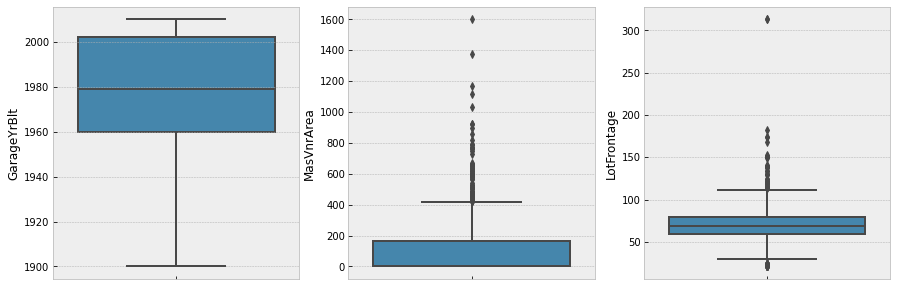

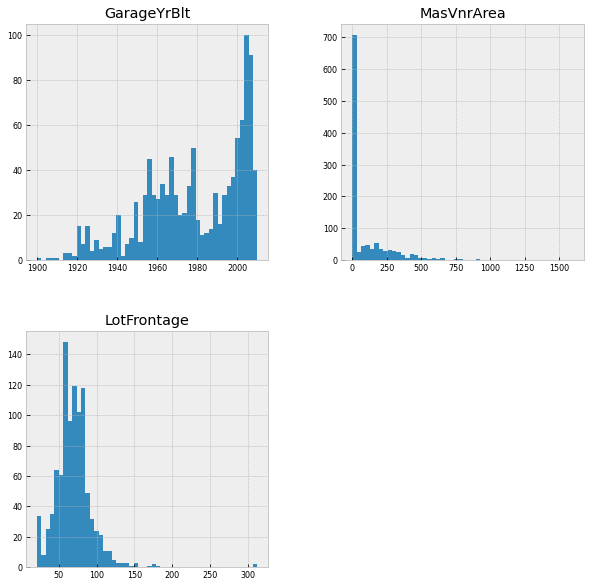

In [62]:
#### Check the distribution of Features with Missing Values
data = PreProcess.drop_un(data, cols = ['Id'])

feat = ['GarageYrBlt', 'MasVnrArea', 'LotFrontage']
EDA.plot_box(data, cols=feat)
EDA.plot_hist_all(data, cols=feat, bins=50, size=(10,10))

EDA.describe(data, feat)

    Filling the missing Values

Fill NAN strategy: mode
Fill NAN strategy: median
Fill NAN strategy: nan_class
Comprehensive aggregate description


Id  MSSubClass MSZoning  LotFrontage  LotArea Street      Alley  \
0        0          30       RL         63.0    13907   Pave  NAN_CLASS   
1        1          50       RL         78.0    11344   Pave  NAN_CLASS   
2        2          60       RL         84.0    14260   Pave  NAN_CLASS   
3        3         190       RM         60.0    11340   Pave  NAN_CLASS   
4        4          60       RL         76.0     9591   Pave  NAN_CLASS   
...    ...         ...      ...          ...      ...    ...        ...   
1163  1163          70       RL         60.0    13515   Pave       Pave   
1164  1164          20       RL         80.0     8700   Pave  NAN_CLASS   
1165  1165         120       RL         32.0    10846   Pave  NAN_CLASS   
1166  1166          60       RL         58.0    17104   Pave  NAN_CLASS   
1167  1167          20       RL         65.0     8773   Pave  NAN_CLASS   

     LotShape LandContour Utilities  ... PoolArea     PoolQC      Fence  \
0         Reg         Lvl    AllPub  ...        0  NAN_CLASS  NAN_CLASS   
1         Reg         Lvl    AllPub  ...        0  NAN_CLASS       GdWo   
2         IR1         Lvl    AllPub  ...        0  NAN_CLASS  NAN_CLASS   
3         Reg         Lvl    AllPub  ...        0  NAN_CLASS  NAN_CLASS   
4         Reg         Lvl    AllPub  ...        0  NAN_CLASS  NAN_CLASS   
...       ...         ...       ...  ...      ...        ...        ...   
1163      Reg         Lvl    AllPub  ...        0  NAN_CLASS      GdPrv   
1164      Reg         Lvl    AllPub  ...        0  NAN_CLASS      MnPrv   
1165      IR1         Lvl    AllPub  ...        0  NAN_CLASS  NAN_CLASS   
1166      IR1         Lvl    AllPub  ...        0  NAN_CLASS  NAN_CLASS   
1167      Reg         Lvl    AllPub  ...        0  NAN_CLASS  NAN_CLASS   

     MiscFeature MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      NAN_CLASS       0      7   2008        WD         Normal     108000  
1      NAN_CLASS       0      7   2007        WD         Normal     144000  
2      NAN_CLASS       0     12   2008        WD         Normal     250000  
3      NAN_CLASS       0      4   2010        WD         Normal     122500  
4      NAN_CLASS       0     10   2007        WD         Normal     317000  
...          ...     ...    ...    ...       ...            ...        ...  
1163   NAN_CLASS       0      7   2007        WD         Normal     180500  
1164   NAN_CLASS       0     12   2008        WD         Normal     155000  
1165   NAN_CLASS       0      5   2008       Con         Normal     324000  
1166   NAN_CLASS       0      9   2006       New        Partial     179665  
1167   NAN_CLASS       0      5   2010        WD         Normal     185500  

[1168 rows x 81 columns]

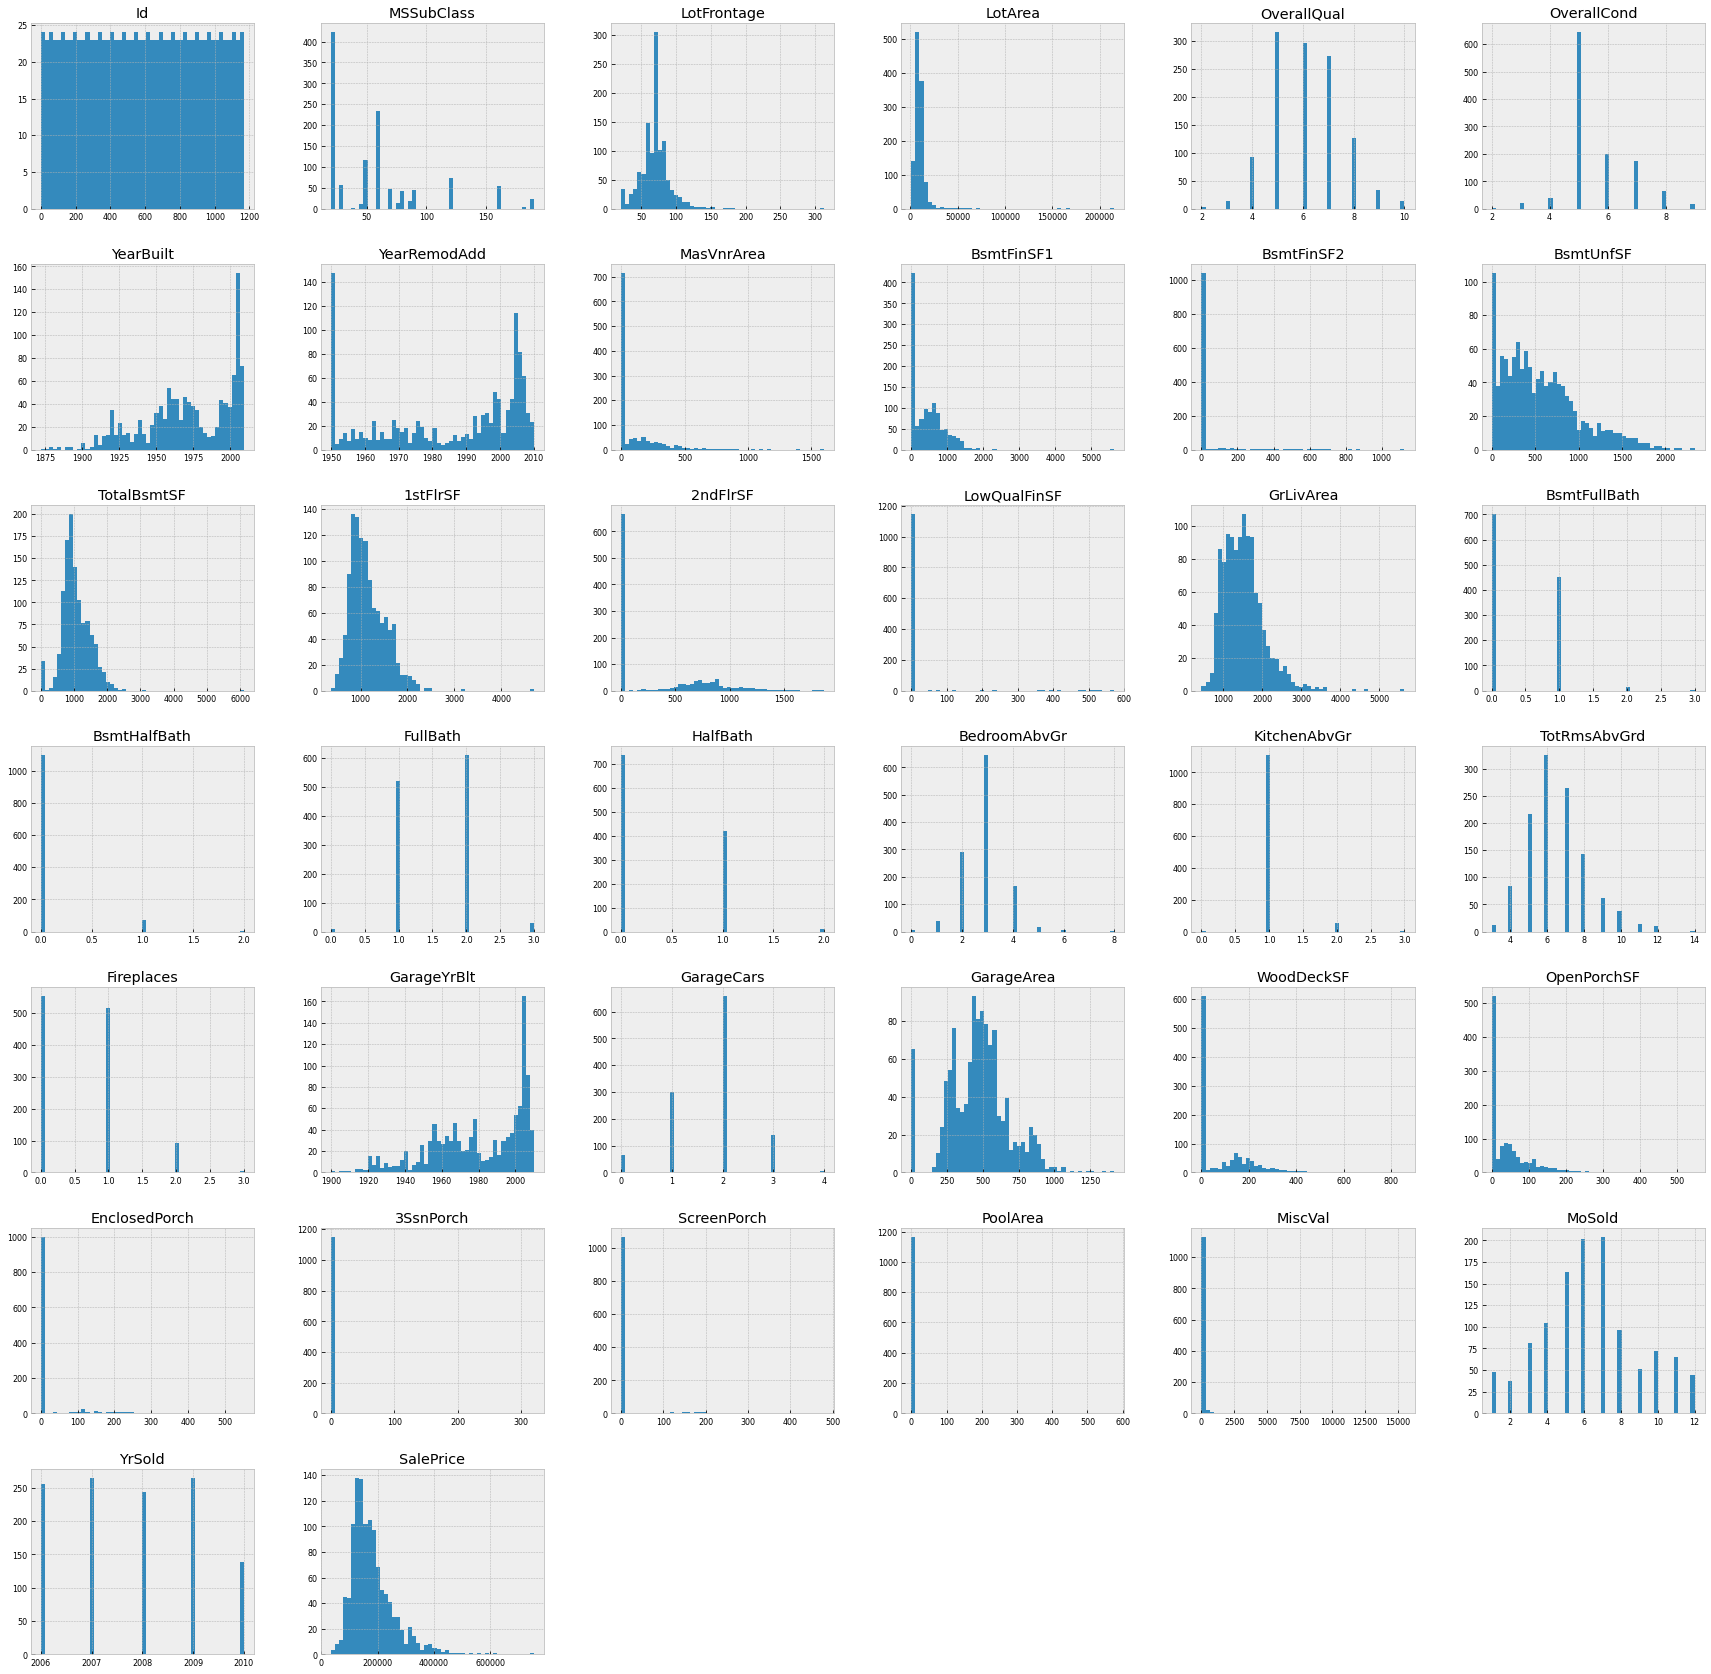

In [81]:
# Filling Missing Values

feat_mode = ['GarageYrBlt', 'MasVnrArea']
feat_median = ['LotFrontage']
feat_na_class = list(set(nan_cols) - set(feat_mode + feat_median))


# New dataframe
data_fld_na = copy(data)
PreProcess.fill_na(data_fld_na, feat_mode, kind='mode')
PreProcess.fill_na(data_fld_na, feat_median, kind='median')
PreProcess.fill_na(data_fld_na, feat_na_class, kind='nan_class')


# Plots after filling nan
EDA.plot_hist_all(data_fld_na, size = (30,30))

# For indivudal hist
# for col in data_fld_na.columns:
#     EDA.plot_dist(data_fld_na, col=col)

# New summary
PreProcess.describe(data_fld_na)
data_fld_na

    Groups of Features
    
    1. Features are grouped into 2 groups - Categorical and Continueous
    2. The plots for these features can be plotted seperately
    3. These two groups can be based on 3 Strategies
       1. IF # Unique classes in features <= 25 THEN Categorical
       2. IF Type(feature) is not integer THEN Categorical 
       3. Manually listing the categorical features
    4. Using Manually listed features for further processing

In [55]:
# Categorical or Continueous
feature_classes = PreProcess.count_unique(data_fld_na)
plot_feat_classes = EDA.plot_grad(feature_classes, col='counts')

# Target feature are - SalePrice
feat_target = ['SalePrice']


# Grouping similar features --> # Based on IF Unique vlues of Features <= 25 then Categorical
feat_categ1, feat_cont1 = PreProcess.group_feat_on_classes(feature_classes, thres=25)


# Grouping similar features --> # Based on If types(feat) == 'int64' then Categorical
feat_categ2, feat_cont2 = PreProcess.group_feat_on_types(data_fld_na)


# Grouping similar features --> # Groups made manually
feat_categ3, feat_cont3 = PreProcess.group_feat_on_manual(data_fld_na, CONFIG)

plot_feat_classes

Counted the Unique Classes in: []
Gradient plot of: counts


In [56]:
# Finall Check: Ensure data is clean
agg = PreProcess.check_agg_all(data_fld_na, cols = feat_categ3)
agg[0:5]

Checking class aggregates of all Columns:


[    ExterCond
 TA       1032
 Gd        114
 Fa         19
 Ex          3,
            GarageCond
 TA               1063
 NAN_CLASS          65
 Fa                 27
 Gd                  6
 Po                  5
 Ex                  2,
            PoolQC
 NAN_CLASS    1165
 Gd              2
 Ex              1,
      LotShape
 Reg       740
 IR1       383
 IR2        36
 IR3         9,
            Fence
 NAN_CLASS    946
 MnPrv        127
 GdPrv         49
 GdWo          35
 MnWw          11]

### FEATURES IMPORTANCE

    TARGET

    1. Distribution of target across samples
    2. Info of target 

Ploting columns: SalePrice


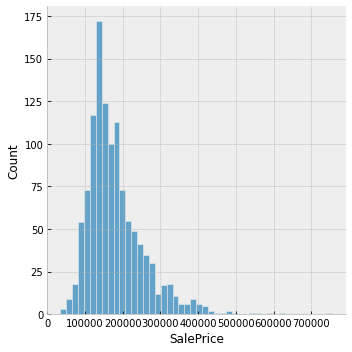

In [57]:
# Check distribution of target
EDA.plot_dist(data, col = feat_target[0])

    CATEGORICAL FEATURES

    1. Feature vs target plots
    2. Observatinos, correlations and Insights
    3. Drop the unnecessary features

Plotting all features distribution.
It may take a while..



[]

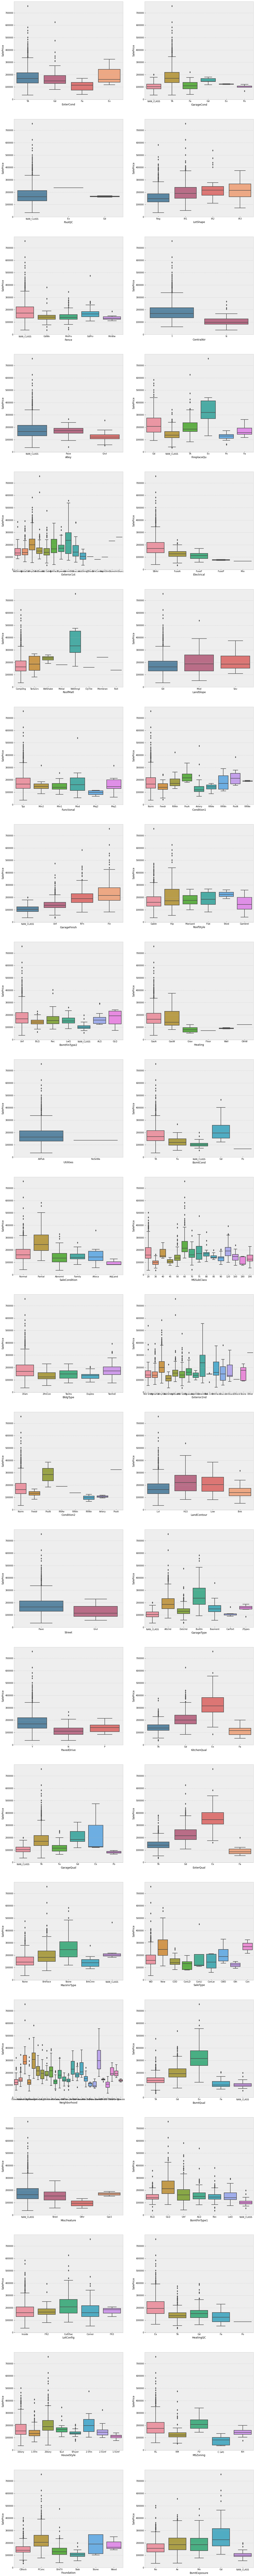

In [29]:
EDA.plot_dist_all(data_fld_na, cols=feat_categ3, kind='box', section=2, target=feat_target[0], size = 10)

Plotting all features distribution.
It may take a while..



[]

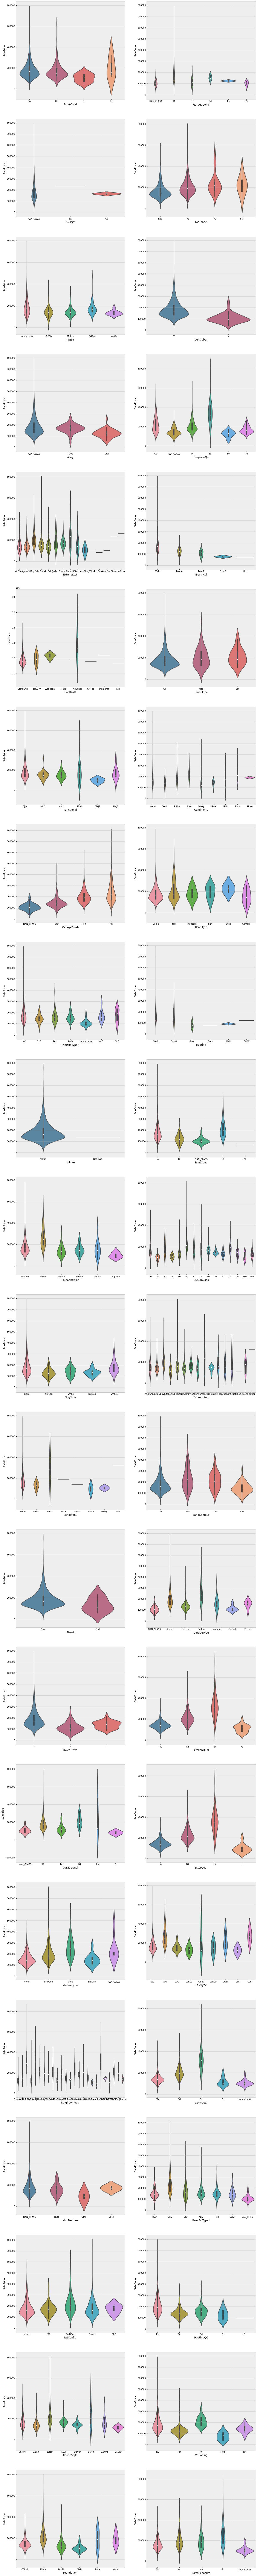

In [30]:
# Violin Plots
EDA.plot_dist_all(data_fld_na, cols=feat_categ3, kind='violin', section=2, target=feat_target[0], size = 10)

    Few Observations from feature-target plots [Categorical]
    
    Correlations:

    1. HeatingQC: Better the quality, higher the SalePrice
    2. BsmtExposure: As the quality increases, prices increases
    3. GarageCond: Counter Intuitively Typical Garage condition houses have 
        high SalePrice
    4. KitcheQuality: Betterr the quality, higher the SalePrice
    5. LotShape: More irregular the shape, higher the SalePrice
    6. GarageQual: Counter Intuitively Typical Garage Quality houses have 
        high + variance in SalePrice. Even mean SalePrice of Typical Garage quality houses is higher than Excellent Garage Quality houses
    7. Electrical: Better the Electrical System, higher is the SalePrice
    8. BsmtQual: Better the quality, higher the SalePrice
    9. PoolQC: Better the quality, higher the SalePrice 
    10. GarageFinish: More finished the garage, higher the SalePrice
    11. BsmtCond: Better the condition, higher the SalePrice

    Other Insights:

    1. Heating: GasA category has exceptionally high SalePrice
    2. SaleCondition: Partially complete houses have high SalePrice
    3.  Exterior2nd: CmentBd has high Mean SalePrice (on average)
    4.  PavedDrive: Houses with paved drive has high SalePrice
    5.  MSZoning: Floating Villace residential have high mean SalePrice, but 
        Medium and Low density regions have high + variance
    6.  RoofMatl: Wood Shingles have high SalePrices, Standad Shingle have   
        high variance
    7.  SaleType: New houses have high SalePrice
    8.  CentralAir: Houses with central air have high SalePrice
    9.  Foundation: Stone, PConc, CBlock, Wood foundation houses have high 
        SalePrice
    10. Condition2: Houses near the Positive Off-site fetches high SalePrice
    11. Street: Paved streets houses have high SalePrice
    12. LandContour: Houses with Banked contour have LOW SalePrice
    13. Alley: Grvl alley have low SalePrice
    14. Functional: Major deduction 2 houses have low SalePrice
    15. HouseStyle: Unfinished storied houses have less SalePrice than Finished Storied houses

    Dropping features
    
    1. Categorical - with high missing values : >80% NAN

In [33]:
# Features with very less data
PreProcess.check_agg_all(data_fld_na, cols = feat_categ3)

data_drop = copy(data_fld_na)
feat_dropped = PreProcess.drop_missing(data_drop, cols=feat_categ3, thresh = 0.8)

# Updated the categorical features
feat_categ3_drop = list(set(feat_categ3) - set(feat_dropped))

Checking class aggregates of all Columns:
dropped col PoolQC
dropped col Fence
dropped col Alley
dropped col MiscFeature
Dropped columns: ['PoolQC', 'Fence', 'Alley', 'MiscFeature'], Couldn't Drop Columns: []


    Observation

    1. Features like Heating, Quality etc have 5 classes -->        
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
       NAN_CLASS No Heating
    2. These classes should be encoded as linear progresstion: To store the relative information
       Ex	5
       Gd	4
       TA	3
       Fa	2
       Po	1
       NAN_CLASS 0

In [66]:
# Encode the Categorical Features

data_categ_enc = data_drop[feat_categ3_drop]
encode_map = PreProcess.encode_categ(data_categ_enc)

data_categ_enc

ExterCond  GarageCond  LotShape  CentralAir  FireplaceQu  Exterior1st  \
0             3           0         0           0            4            0   
1             3           3         0           0            0            1   
2             3           3         1           0            3            2   
3             3           3         0           0            0            2   
4             3           3         0           0            4            2   
...         ...         ...       ...         ...          ...          ...   
1163          3           3         0           0            4            4   
1164          4           3         0           0            0            1   
1165          3           3         1           0            4            5   
1166          3           3         1           0            4            2   
1167          3           3         0           0            0            2   

      RoofMatl  LandSlope  Functional  Condition1  ...  SaleType  \
0            0          0           0           0  ...         0   
1            0          0           0           1  ...         0   
2            0          0           0           0  ...         0   
3            0          0           0           0  ...         0   
4            0          0           0           0  ...         0   
...        ...        ...         ...         ...  ...       ...   
1163         0          0           0           0  ...         0   
1164         0          0           0           0  ...         0   
1165         0          0           0           0  ...         8   
1166         0          0           0           0  ...         1   
1167         0          0           0           0  ...         0   

      Neighborhood  BsmtQual  BsmtFinType1  LotConfig  HeatingQC  HouseStyle  \
0                0         3             0          0          5           0   
1                1         3             0          0          3           1   
2                2         4             1          1          5           2   
3                3         3             2          0          4           2   
4                4         5             2          0          5           2   
...            ...       ...           ...        ...        ...         ...   
1163             9         3             2          0          5           2   
1164             1         3             3          0          4           0   
1165            15         4             1          2          5           0   
1166             7         4             1          0          5           2   
1167             6         4             1          1          5           0   

      MSZoning  Foundation  Electrical  
0            0           0           0  
1            0           0           1  
2            0           1           0  
3            1           1           0  
4            0           1           0  
...        ...         ...         ...  
1163         0           1           1  
1164         0           0           0  
1165         0           1           0  
1166         0           1           0  
1167         0           1           0  

[1168 rows x 40 columns]

    CONTINUEOUS FEATURES

    1. Distribution of continueous features
    2. Feature v Target plots
    3. Feature v Target correlations
    4. Analysis

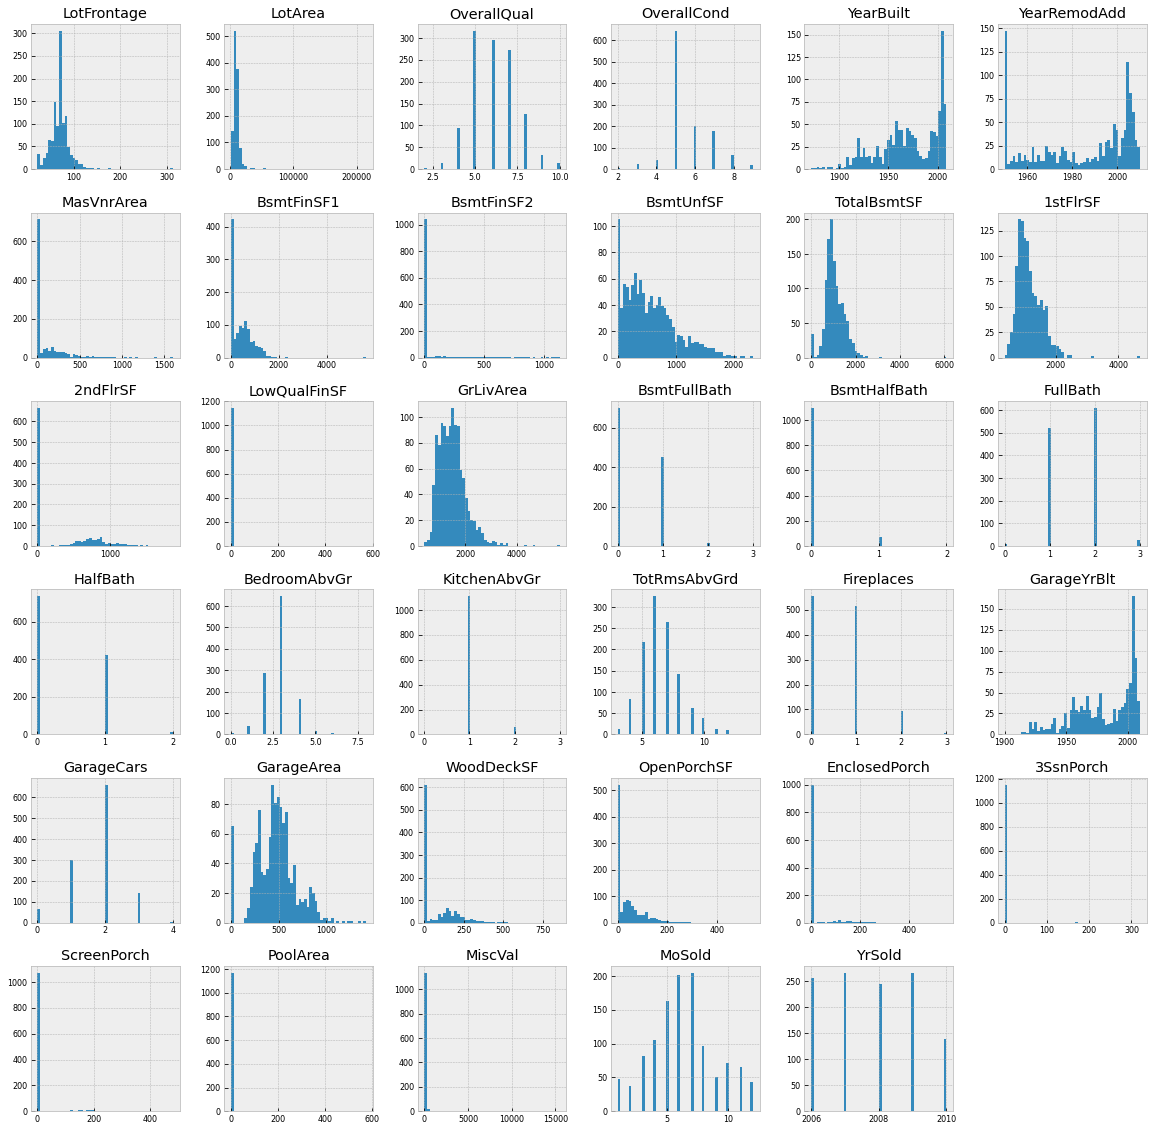

In [67]:
# Check distribution of Continueous features
EDA.plot_hist_all(data_drop, cols=feat_cont3, size=(20,20))

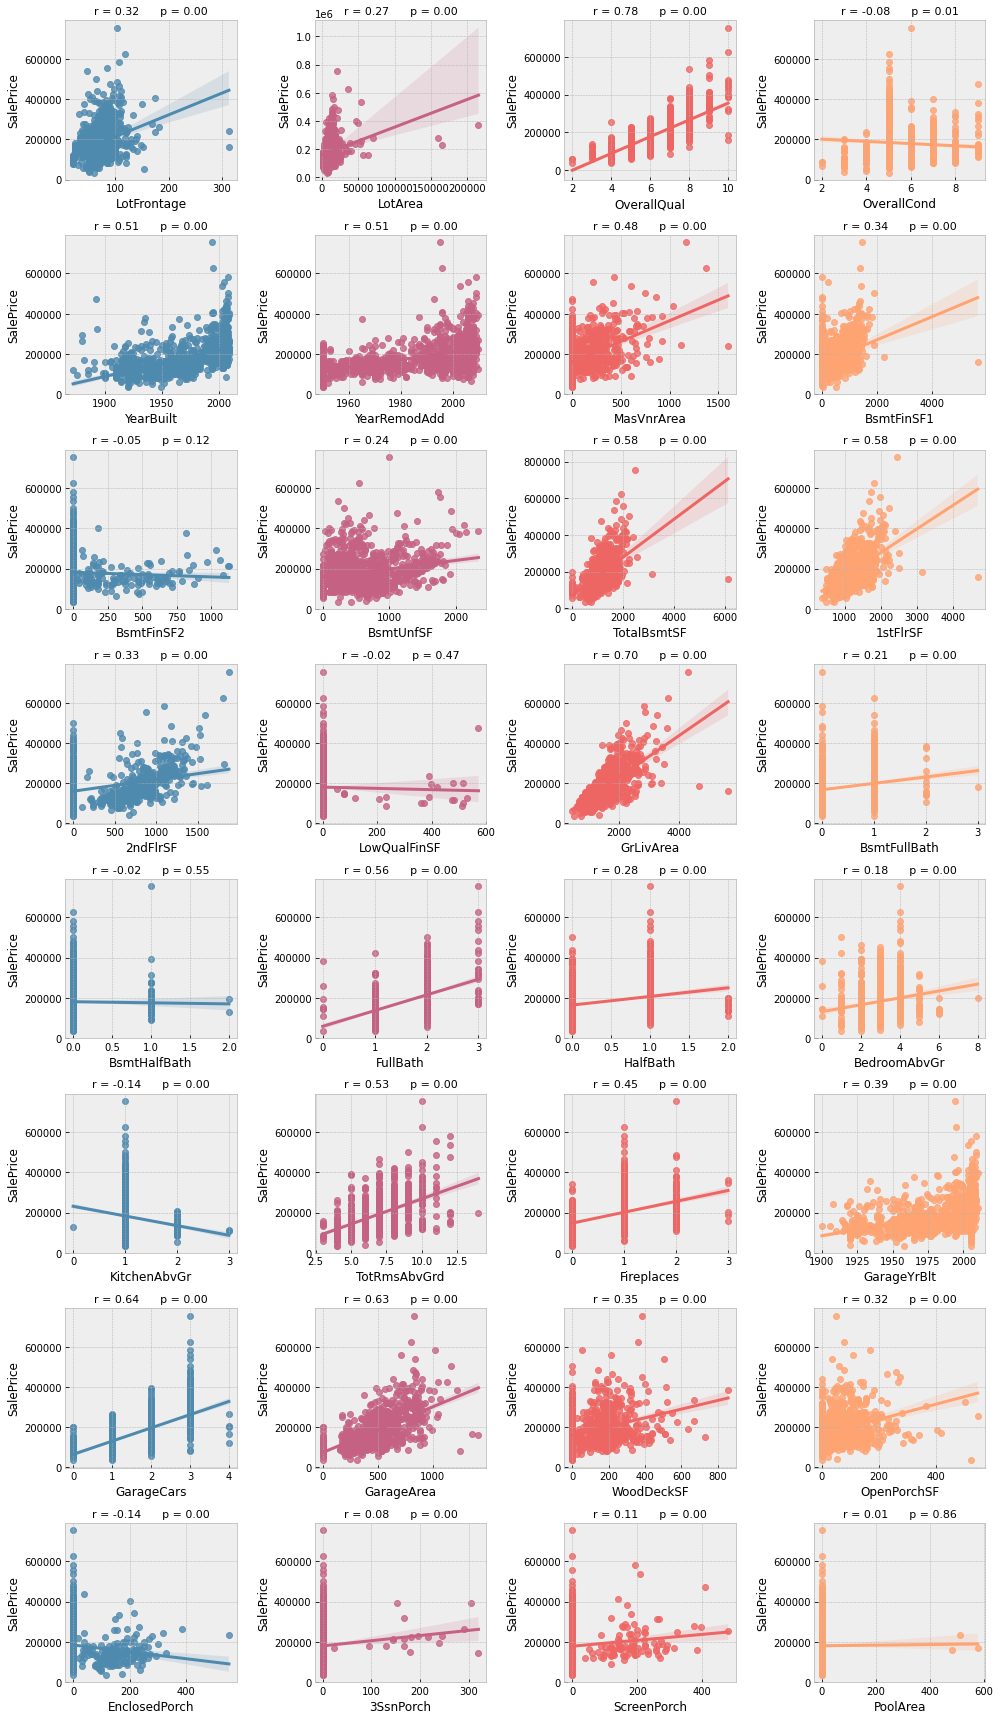

In [68]:
# Check pair-wise similarity with target
EDA.pair_wise_corr(data_drop, cols=feat_cont3, size=(20,20), section=4, colors=colors)

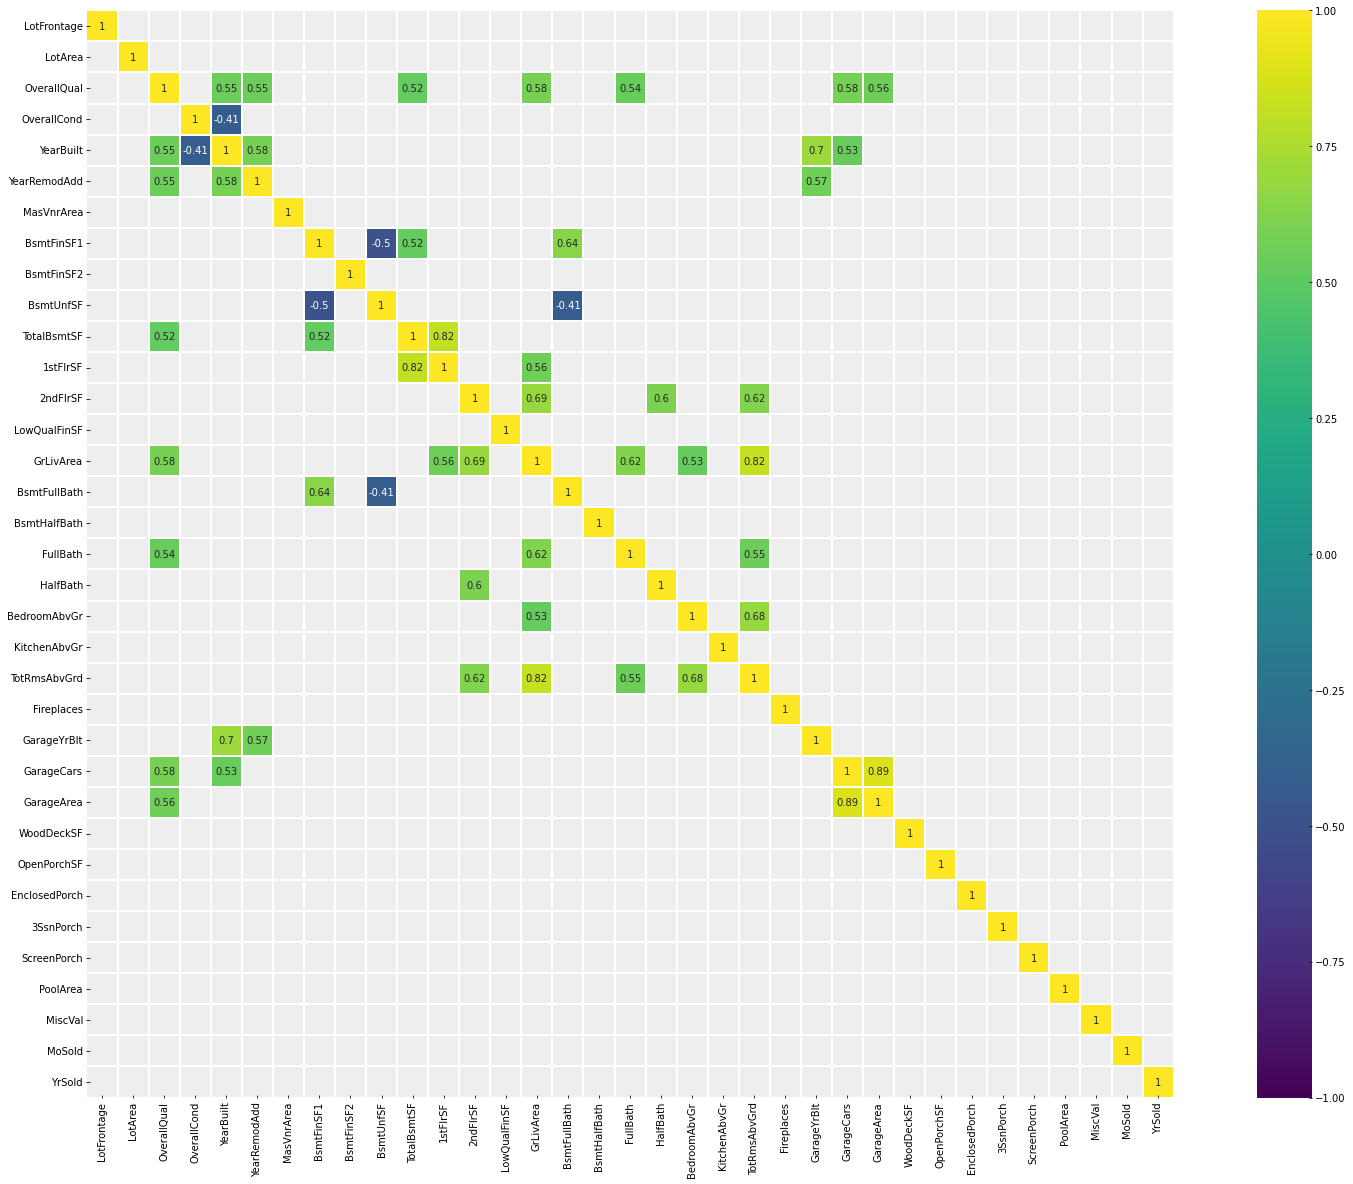

In [69]:
# Check pair-wise similarity among features
EDA.corr_cont_feat(data_drop, cols=feat_cont3, size= (30,20))

    Observations

    1. Strong Positive Correlated features are
       1. GarageArea | GarageCars - 0.89 --> Garage cars are proportional to Area
       2. TotalRmsAbvGrd | GLivArea - 0.82
       3. 1stFlrSF | TotalBsmtSF - 0.82 --> First Floor surface are is proportional to Basement surface area
       4. GarageYrBlt | YearBuilt - 0.7 --> Garage of the house is built in same year (or in near years)
       5. GLivArea | 2ndFlrSF - 0.69 --> Proportional to each other
       6. BsmtFullBath | BasmtFinSF1 - 0.64 --> More finished are have high chance of having full bath


    2. Strong Negative correlated features are
       1. BsmtFullBath | BasmtUnSF1 - (-0.4) --> More unfinished area have high chance of NOT having full bath
       2. BsmtFinSF1 | BasmtUnSF1 - (-0.5) --> Trivially
       3. YearBuilt | OverallCond - (-0.5) --> Counterintutively, Old houses have better Overall Condition



In [70]:
# List the important features
corr, styled = EDA.get_pearson_corr(data_drop, cols=feat_cont3, target=feat_target[0])
styled

    Choosing important continueous features

    1. r-value and p-value both should be considered in deciding important features
    2. High absolute value of r-value AND Very Low p-value (< 0.05 for statictical significance) are most favorable

In [74]:
# Drop features with low r-value and high-pvalue
data_cont = data_drop[feat_cont3]
feat_cont3_imp = list(corr[abs(corr['r-value']) > 0.25]['feat'])
data_cont = data_cont[feat_cont3_imp]

data_cont


OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  1stFlrSF  \
0               5        996           0           0          996       996   
1               5       1524           1         315          874       874   
2               8       2198           3         836         1145      1145   
3               4       2290           2         560          777      1246   
4               8       2473           3         852         1143      1143   
...           ...        ...         ...         ...          ...       ...   
1163            6       1824           2         520          764      1060   
1164            5       1128           2         525         1120      1128   
1165            8       1719           2         473         1719      1719   
1166            7       1496           2         426          654       664   
1167            7       1414           2         494         1414      1414   

      FullBath  TotRmsAbvGrd  YearBuilt  YearRemodAdd  MasVnrArea  Fireplaces  \
0            1             6       1940          1969         0.0           1   
1            1             7       1958          1958       180.0           0   
2            2             9       2000          2000       350.0           1   
3            2            11       1885          1950         0.0           0   
4            2             9       2004          2005       344.0           1   
...        ...           ...        ...           ...         ...         ...   
1163         1             8       1919          1950         0.0           1   
1164         2             6       1963          1963       148.0           0   
1165         1             6       1993          1993         0.0           2   
1166         2             7       2006          2006         0.0           1   
1167         2             6       2004          2004        98.0           0   

      GarageYrBlt  WoodDeckSF  BsmtFinSF1  2ndFlrSF  OpenPorchSF  LotFrontage  \
0          2005.0         144         290         0            0         63.0   
1          1958.0           0         460       650            0         78.0   
2          2000.0         192         655      1053           84         84.0   
3          1971.0           0           0      1044            0         60.0   
4          2004.0         192           0      1330          151         76.0   
...           ...         ...         ...       ...          ...          ...   
1163       1940.0           0           0       764            0         60.0   
1164       1963.0         192         776         0           20         80.0   
1165       1993.0         122        1619         0           30         32.0   
1166       2006.0         100         554       832           24         58.0   
1167       2004.0         132          24         0          105         65.0   

      HalfBath  LotArea  
0            0    13907  
1            1    11344  
2            1    14260  
3            0    11340  
4            1     9591  
...        ...      ...  
1163         0    13515  
1164         0     8700  
1165         1    10846  
1166         1    17104  
1167         0     8773  

[1168 rows x 20 columns]

In [76]:
# Clubbing the datas of categorical and continueous features

data_final = pd.concat([data_categ_enc, data_cont], axis=1, join='inner')
data_final


ExterCond  GarageCond  LotShape  CentralAir  FireplaceQu  Exterior1st  \
0             3           0         0           0            4            0   
1             3           3         0           0            0            1   
2             3           3         1           0            3            2   
3             3           3         0           0            0            2   
4             3           3         0           0            4            2   
...         ...         ...       ...         ...          ...          ...   
1163          3           3         0           0            4            4   
1164          4           3         0           0            0            1   
1165          3           3         1           0            4            5   
1166          3           3         1           0            4            2   
1167          3           3         0           0            0            2   

      RoofMatl  LandSlope  Functional  Condition1  ...  MasVnrArea  \
0            0          0           0           0  ...         0.0   
1            0          0           0           1  ...       180.0   
2            0          0           0           0  ...       350.0   
3            0          0           0           0  ...         0.0   
4            0          0           0           0  ...       344.0   
...        ...        ...         ...         ...  ...         ...   
1163         0          0           0           0  ...         0.0   
1164         0          0           0           0  ...       148.0   
1165         0          0           0           0  ...         0.0   
1166         0          0           0           0  ...         0.0   
1167         0          0           0           0  ...        98.0   

      Fireplaces  GarageYrBlt  WoodDeckSF  BsmtFinSF1  2ndFlrSF  OpenPorchSF  \
0              1       2005.0         144         290         0            0   
1              0       1958.0           0         460       650            0   
2              1       2000.0         192         655      1053           84   
3              0       1971.0           0           0      1044            0   
4              1       2004.0         192           0      1330          151   
...          ...          ...         ...         ...       ...          ...   
1163           1       1940.0           0           0       764            0   
1164           0       1963.0         192         776         0           20   
1165           2       1993.0         122        1619         0           30   
1166           1       2006.0         100         554       832           24   
1167           0       2004.0         132          24         0          105   

      LotFrontage  HalfBath  LotArea  
0            63.0         0    13907  
1            78.0         1    11344  
2            84.0         1    14260  
3            60.0         0    11340  
4            76.0         1     9591  
...           ...       ...      ...  
1163         60.0         0    13515  
1164         80.0         0     8700  
1165         32.0         1    10846  
1166         58.0         1    17104  
1167         65.0         0     8773  

[1168 rows x 60 columns]

    Analysis

    1. Now we have categorical encoded and continueous important features 
       1. 40 (categorical) + 20 (continueous)
    2. Let's look into the PCA and TSNE of 1168 X 61 feature matrix
       1. TSNE - Local Structure
       2. PCA - Global Structure
       3. 

In [78]:
X = data_final.values

tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
X

ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

0.7978118497716112


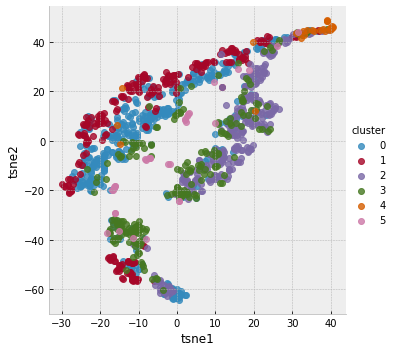

In [ ]:

features = feat_cont3_imp + feat_categ3_drop

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)

kmeans = KMeans(n_clusters=6)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

#### TRY AND COMPARE MODELS


#### ROUGH WORK

In [ ]:
# from scipy import stats

# df = copy(data_fld_na)

# cols = feat_cont3
# bins = 50
# size = (10, 10)

# section = 2

# target = "SalePrice"

# rows = len(cols)//section
# secs = section

# fig, axs = plt.subplots(rows, secs, figsize=(secs*3.5,rows*3))

# for r in range(0,rows):
#     for c in range(0,secs):
#         i = r*secs + c
#         if i < len(cols):
#             sns.regplot(df[cols[i]], df[target], ax = axs[r][c])
#             stp = stats.pearsonr(df[cols[i]], df[target])
#             str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
#             axs[r][c].set_title(str_title,fontsize=11)
# plt.tight_layout()    
# plt.show()  


# sns.regplot(df[cols[0]], df[target])#, ax = axs[r][c])
# plt.show()

# df = copy(data_fld_na)
# thresh = 0.8 * df.shape[0]
# cols = feat_categ3
# skipped_cols = []
# if not cols: cols = df.columns


# for col in cols:
#     try:
#         agg = df[col].value_counts().to_frame('counts').T
#         print(agg)
#         print(col)
#         cross_thresh = (agg['NAN_CLASS'] > thresh).any()
#         if cross_thresh:
#             df.drop(col , inplace=True, axis=1)
#     except Exception as er:
#         print(er)
#         skipped_cols.append(col)
#     break

# print(f"Couldn't Drop Columns: {skipped_cols}")
# agg = df[col].value_counts().to_frame('counts').T

# agg = df['Paved'].value_counts().to_frame('counts').T
# agg = df['PavedDrive'].value_counts().to_frame(name='counts').T

# rows = len(cols)//section
# secs = len(cols)%section

# print(len(cols), len(cols)//section, len(cols)% section)

### ARCHIVES

In [ ]:
# Before Cleaning Plots
# EDA.plot_all_dist(data)

# def plot_all_bar(df, target=""):
#     print(f"Plotting all features.\nIt may take a while..", end="\n\n")
#     plt.figure(figsize=(20, 10))
#     plot_id = 321
#     skipped_cols = []
#     def _plot_one(df, col):
#         try:
#             plt.subplot(plot_id)
#             sns.barplot(x = col, y = target, data = df)
#         except: skipped_cols.append(col)

#     for col in df.columns:
#         _plot_one(df, col)
#         plot_id += 1
    
#     print(f"Few columns faced exception: {skipped_cols}")